<a href="https://colab.research.google.com/github/Angel-Shaha/YouTube-Comment-Analyser/blob/main/Sentiment_Analysis_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
yt_data = pd.read_csv('/content/SentimentDataset_gh.csv')

In [ ]:
yt_data.head()

,Text,Label,Sentiment
0,"Cooking microwave pizzas, yummy",2,positive
1,Any plans of allowing sub tasks to show up in ...,1,neutral
2,"I love the humor, I just reworded it. Like sa...",2,positive
3,naw idk what ur talkin about,1,neutral
4,That sucks to hear. I hate days like that,0,negative


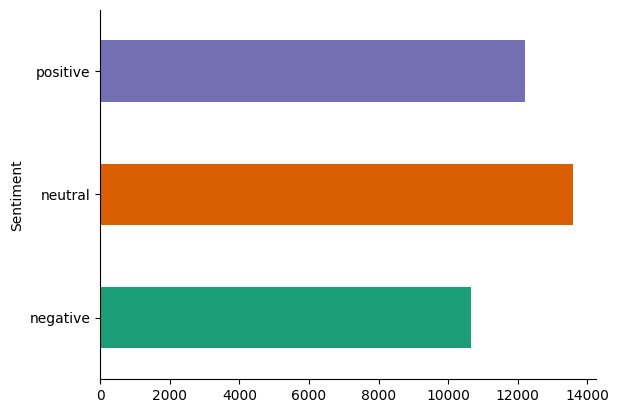

In [ ]:
# @title Sentiment

from matplotlib import pyplot as plt
import seaborn as sns
yt_data.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
yt_data.Label.value_counts()

1    13575
2    12208
0    10650
Name: Label, dtype: int64

In [ ]:
port_stem= PorterStemmer()

def stemming(content):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', content)
  stemmed_content=re.sub('[^a-zA-Z]',' ',cleantext) #^to remove the words which are not letters
  stemmed_content=stemmed_content.lower() #convert all to lowercase
  stemmed_content=stemmed_content.split() #splitting and storing in a list
  stemmed_content=[port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')] #if word does not belong to stem words then process the stemmed content
  stemmed_content=' '.join(stemmed_content) #joining all tweets

  return stemmed_content

yt_data['stemmed_content']= yt_data['Text'].apply(stemming)

In [ ]:
yt_data.head()

,Text,Label,Sentiment,stemmed_content
0,"Cooking microwave pizzas, yummy",2,positive,cook microwav pizza yummi
1,Any plans of allowing sub tasks to show up in ...,1,neutral,plan allow sub task show widget
2,"I love the humor, I just reworded it. Like sa...",2,positive,love humor reword like say group therapi inste...
3,naw idk what ur talkin about,1,neutral,naw idk ur talkin
4,That sucks to hear. I hate days like that,0,negative,suck hear hate day like


In [ ]:
from sklearn.model_selection import train_test_split

# separating the data as texts and label

X = yt_data['Text']

Y = yt_data['Label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

print(X.shape)
print(X_train.shape)
print(X_test.shape)

(36433,)
(32789,)
(3644,)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=50000,

                      lower=True,
                      split=' ',
                      char_level=False,
                      oov_token='<UNK>',
                      document_count=0)

In [ ]:
print(X_train)

13465    _MC string out the dress.. Work that into a tr...
32137    got my cable set up! WIN!  got my lock put on ...
6772     Morning ;Sports day today, and I have to do th...
15550    Thank you OpenDNS for saving me from Comcast`s...
15813    On a day like today. I am thankful for my mom`...
                               ...                        
16370                 doing pretty well, up and wide awake
16478     Beto`s Pizzeria is on Banksville Rd in I beli...
28154                             It`s teddy-chucking time
29830    i am loving this and plan to buy it. do you in...
11910                                          Young money
Name: Text, Length: 32789, dtype: object


In [ ]:
print(type(Y_train))
# print(Y_train.head())

Y_train = Y_train.astype(str)
tokenizer.fit_on_texts(Y_train)

<class 'pandas.core.series.Series'>


In [ ]:
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(Y_train)

wordindex=tokenizer.word_index

In [ ]:
tokenizer_config = tokenizer.get_config()
tokenizer_config.keys()
#tokenizer_config['word_counts']

dict_keys(['num_words', 'filters', 'lower', 'split', 'char_level', 'oov_token', 'document_count', 'word_counts', 'word_docs', 'index_docs', 'index_word', 'word_index'])

In [ ]:
import tensorflow.keras.preprocessing.sequence as ps

In [ ]:
max_length = 50
train_sequence = tokenizer.texts_to_sequences(X_train)
train_padding = ps.pad_sequences(train_sequence,maxlen=max_length,padding='post')

test_sequence = tokenizer.texts_to_sequences(X_test)
test_padding = ps.pad_sequences(test_sequence,maxlen=max_length,padding='post')

In [ ]:
#print(test_padding[0])
#train_padding[0]
train_padding.shape
Y_train.shape

(32789,)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
Y_train = pd.DataFrame(Y_train)

y_train = OneHotEncoder().fit_transform(Y_train)

y_train.shape

(32789, 3)

In [ ]:


Y_test = pd.DataFrame(Y_test)
y_test = OneHotEncoder().fit_transform(Y_test)
y_test.shape

(3644, 3)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding,Dropout, Bidirectional

from keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling1D

# **RNN**

In [ ]:
# Building the BASELINE MODEL
base_model = Sequential()
base_model.add(Embedding(50000,128,input_length=train_padding.shape[1]))
base_model.add(GlobalAveragePooling1D())
base_model.add(Dense(8,activation='relu'))
base_model.add(Dense(3,activation='softmax'))

In [ ]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           6400000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 6401059 (24.42 MB)
Trainable params: 6401059 (24.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Compiling the model

base_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
y_train=np.array(y_train.toarray())
train_padding=np.array(train_padding)

In [ ]:

# # Define the early stopping criteria
# early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

#Fitting the model

history_base = base_model.fit(train_padding,y_train ,epochs=30, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience=2)])

Epoch 1/30
820/820 [==============================] - 76s 92ms/step - loss: 0.9344 - accuracy: 0.5478 - val_loss: 0.8178 - val_accuracy: 0.6409
Epoch 2/30
820/820 [==============================] - 75s 92ms/step - loss: 0.7049 - accuracy: 0.7075 - val_loss: 0.7677 - val_accuracy: 0.6661
Epoch 3/30
820/820 [==============================] - 79s 96ms/step - loss: 0.5937 - accuracy: 0.7685 - val_loss: 0.7625 - val_accuracy: 0.6752
Epoch 4/30
820/820 [==============================] - 80s 97ms/step - loss: 0.5055 - accuracy: 0.8095 - val_loss: 0.8106 - val_accuracy: 0.6589
Epoch 5/30
820/820 [==============================] - 90s 110ms/step - loss: 0.4337 - accuracy: 0.8407 - val_loss: 0.8395 - val_accuracy: 0.6629


<ipython-input-26-4c115d5840cd>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


(0.0, 0.9594089105725289)

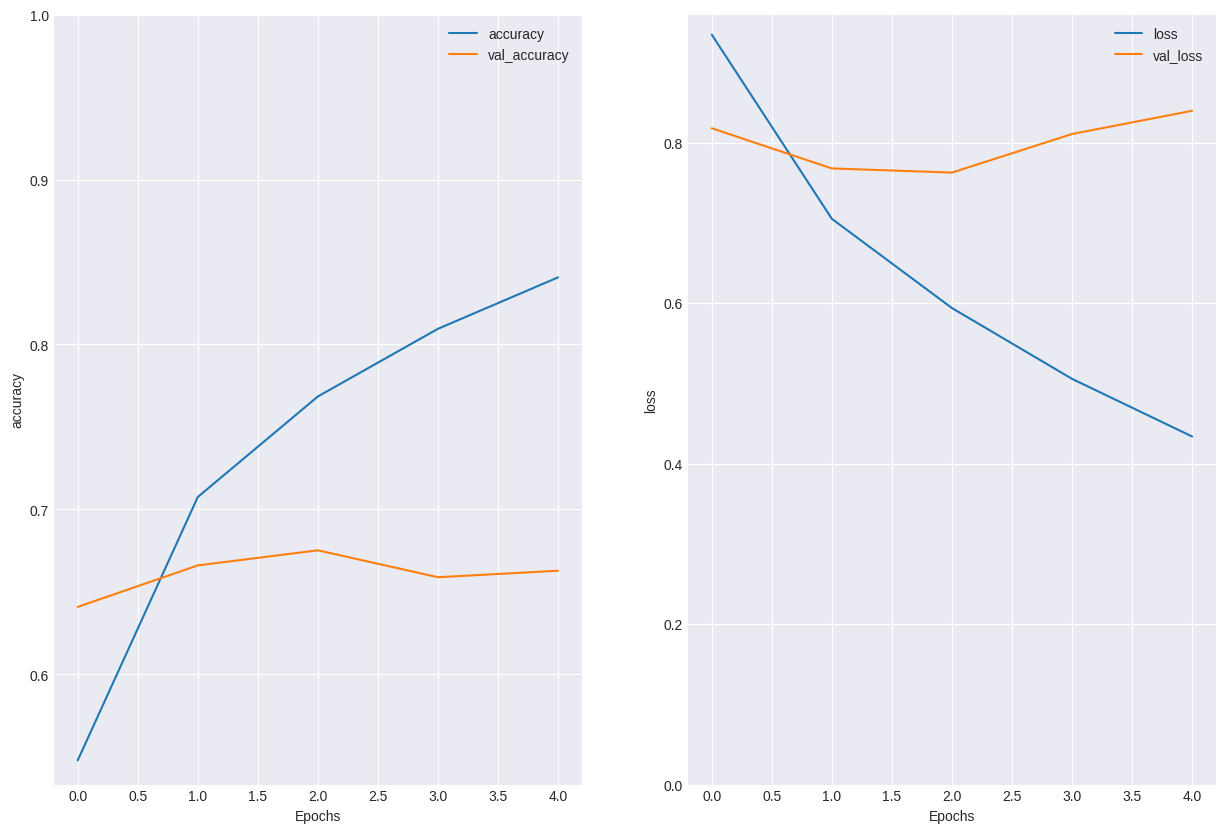

In [ ]:
plt.style.use('seaborn-darkgrid')
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history_base, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_base, 'loss')
plt.ylim(0, None)

In [ ]:
score = base_model.evaluate(test_padding,y_test.toarray())
print("Testing Accuracy(%): ", score[1]*100)

114/114 [==============================] - 0s 4ms/step - loss: 0.8747 - accuracy: 0.6534
Testing Accuracy(%):  65.34028649330139


In [ ]:
y_pred = model_r.predict(test_padding)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in y_test])

114/114 [==============================] - 0s 4ms/step


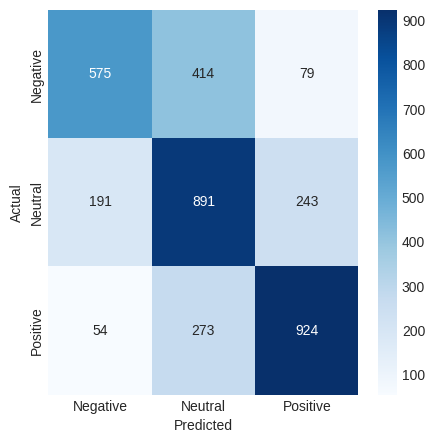

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_labels, y_predicted_labels)

import seaborn as sn
labels=['Negative', 'Neutral','Positive']
plt.figure(figsize=(5,5))
sn.heatmap(cm,  xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
print('\n=================Classification Report========================\n')
print(classification_report(y_test_labels, y_predicted_labels, target_names=['Class  Negative',	 'Class Neutral','Class positive']))


=================Classification Report========================

                 precision    recall  f1-score   support

Class  Negative       0.70      0.54      0.61      1068
  Class Neutral       0.56      0.67      0.61      1325
 Class positive       0.74      0.74      0.74      1251

       accuracy                           0.66      3644
      macro avg       0.67      0.65      0.65      3644
   weighted avg       0.67      0.66      0.66      3644



# **RNN regularized**

In [ ]:
import tensorflow

regularise = tensorflow.keras.regularizers.l2(0.001)

model_r = Sequential()
model_r.add(Embedding(50000,128,input_length=train_padding.shape[1]))
model_r.add(Dropout(0.5))
model_r.add(GlobalAveragePooling1D())
model_r.add(Dense(8,activation='relu',kernel_regularizer=regularise))
model_r.add(Dropout(0.5))
model_r.add(Dense(3,activation='softmax'))
model_r.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           6400000   
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                      

In [ ]:
#Compiling the model
model_r.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
#Fitting the model

history_r = model_r.fit(train_padding,y_train ,epochs=30, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience=2)])

Epoch 1/30
820/820 [==============================] - 85s 102ms/step - loss: 1.0842 - accuracy: 0.3984 - val_loss: 1.0274 - val_accuracy: 0.5159
Epoch 2/30
820/820 [==============================] - 81s 99ms/step - loss: 0.9909 - accuracy: 0.4766 - val_loss: 0.9205 - val_accuracy: 0.6252
Epoch 3/30
820/820 [==============================] - 78s 96ms/step - loss: 0.9305 - accuracy: 0.5244 - val_loss: 0.8706 - val_accuracy: 0.6519
Epoch 4/30
820/820 [==============================] - 82s 100ms/step - loss: 0.8890 - accuracy: 0.5502 - val_loss: 0.8464 - val_accuracy: 0.6615
Epoch 5/30
820/820 [==============================] - 85s 104ms/step - loss: 0.8601 - accuracy: 0.5697 - val_loss: 0.8274 - val_accuracy: 0.6735
Epoch 6/30
820/820 [==============================] - 79s 96ms/step - loss: 0.8386 - accuracy: 0.5864 - val_loss: 0.8182 - val_accuracy: 0.6688
Epoch 7/30
820/820 [==============================] - 85s 104ms/step - loss: 0.8175 - accuracy: 0.6006 - val_loss: 0.8132 - val_accur

(0.0, 1.1014065086841582)

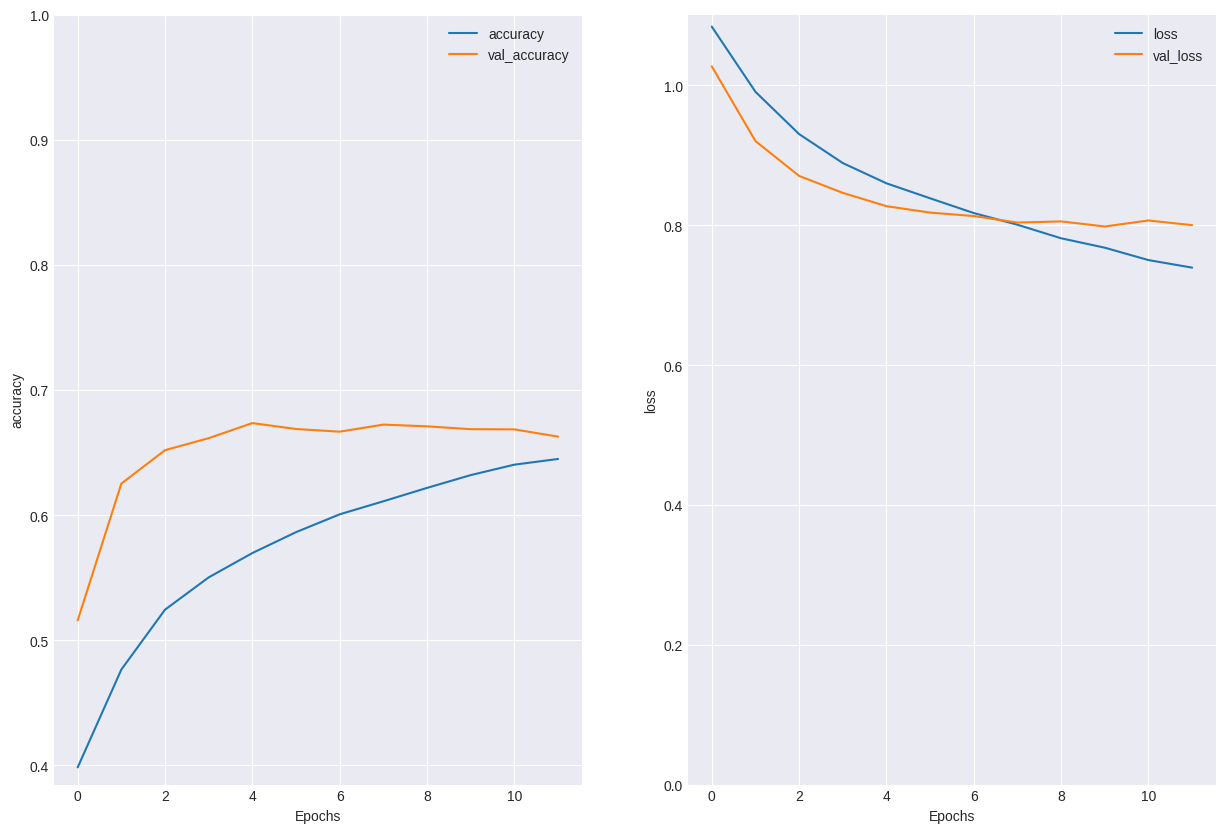

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history_r, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_r, 'loss')
plt.ylim(0, None)

In [ ]:
score = model_r.evaluate(test_padding,y_test.toarray())
print("Testing Accuracy(%): ", score[1]*100)

114/114 [==============================] - 0s 3ms/step - loss: 0.8130 - accuracy: 0.6559
Testing Accuracy(%):  65.5872642993927


In [ ]:
y_pred = model_r.predict(test_padding)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in y_test])

114/114 [==============================] - 0s 2ms/step


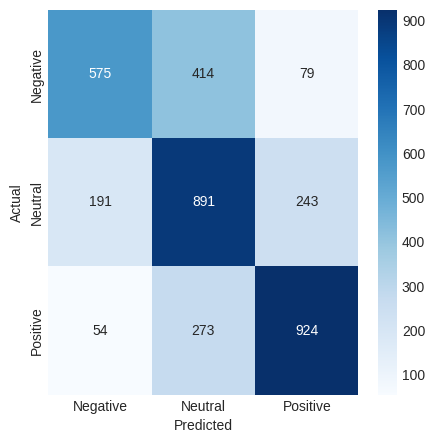

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_labels, y_predicted_labels)

import seaborn as sn
labels=['Negative', 'Neutral','Positive']
plt.figure(figsize=(5,5))
sn.heatmap(cm,  xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
print('\n=================Classification Report========================\n')
print(classification_report(y_test_labels, y_predicted_labels, target_names=['Class  Negative',	 'Class Neutral','Class positive']))


=================Classification Report========================

                 precision    recall  f1-score   support

Class  Negative       0.70      0.54      0.61      1068
  Class Neutral       0.56      0.67      0.61      1325
 Class positive       0.74      0.74      0.74      1251

       accuracy                           0.66      3644
      macro avg       0.67      0.65      0.65      3644
   weighted avg       0.67      0.66      0.66      3644



# **GRU**

In [ ]:
from keras.layers import GRU

# Building the improved model
model_gru = Sequential()
model_gru.add(Embedding(50000, 128, input_length=train_padding.shape[1]))
model_gru.add(Dropout(0.5))
model_gru.add(GRU(32))
model_gru.add(Dense(32,activation='relu',kernel_regularizer=regularise))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(3, activation='softmax'))

# Compiling the model
model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model with early stopping callback
history_gru = model_gru.fit(train_padding, y_train, epochs=30, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience=2)])


Epoch 1/30
820/820 [==============================] - 96s 113ms/step - loss: 1.1035 - accuracy: 0.3688 - val_loss: 1.0958 - val_accuracy: 0.3711
Epoch 2/30
820/820 [==============================] - 92s 112ms/step - loss: 1.0931 - accuracy: 0.3814 - val_loss: 1.0924 - val_accuracy: 0.3812
Epoch 3/30
820/820 [==============================] - 94s 115ms/step - loss: 1.0842 - accuracy: 0.3931 - val_loss: 1.0904 - val_accuracy: 0.3841
Epoch 4/30
820/820 [==============================] - 94s 114ms/step - loss: 1.0516 - accuracy: 0.4281 - val_loss: 0.9558 - val_accuracy: 0.5303
Epoch 5/30
820/820 [==============================] - 93s 114ms/step - loss: 0.8505 - accuracy: 0.5945 - val_loss: 0.7706 - val_accuracy: 0.6601
Epoch 6/30
820/820 [==============================] - 94s 115ms/step - loss: 0.7010 - accuracy: 0.7043 - val_loss: 0.7574 - val_accuracy: 0.6734
Epoch 7/30
820/820 [==============================] - 105s 128ms/step - loss: 0.6083 - accuracy: 0.7598 - val_loss: 0.7802 - val_a

(0.0, 1.1323542088270186)

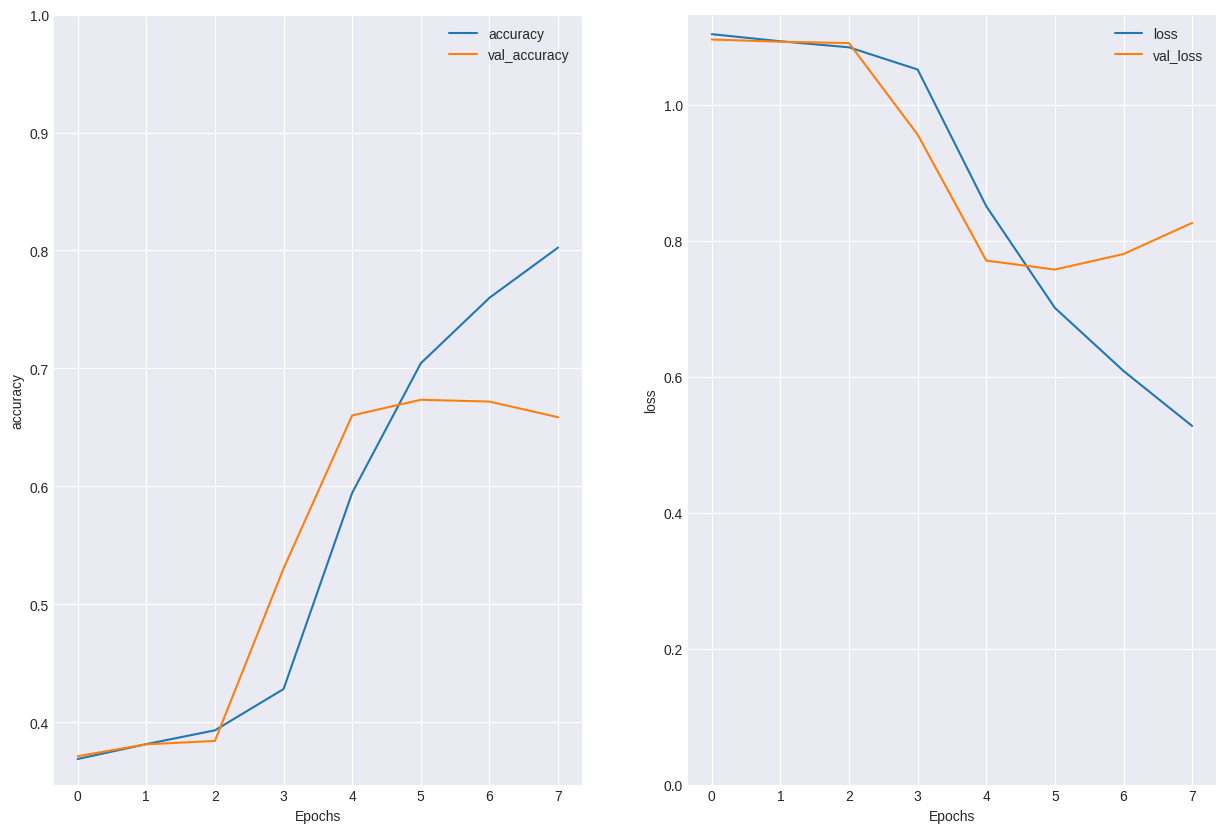

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history_gru, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_gru, 'loss')
plt.ylim(0, None)

In [ ]:
score = model_gru.evaluate(test_padding,y_test.toarray())
print("Testing Accuracy(%): ", score[1]*100)

114/114 [==============================] - 1s 8ms/step - loss: 0.8339 - accuracy: 0.6534
Testing Accuracy(%):  65.34028649330139


In [ ]:
y_pred = model_gru.predict(test_padding)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in y_test])

114/114 [==============================] - 1s 8ms/step


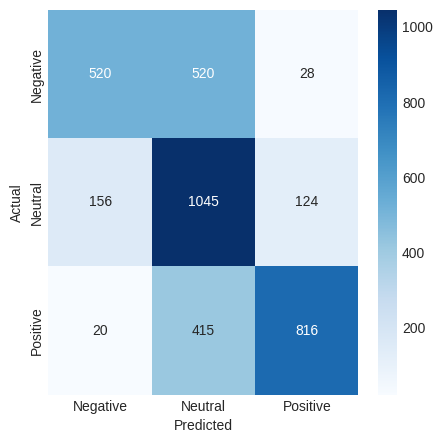

In [ ]:
cm = confusion_matrix(y_test_labels, y_predicted_labels)

labels=['Negative', 'Neutral','Positive']
plt.figure(figsize=(5,5))
sn.heatmap(cm,  xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print('\n=================Classification Report========================\n')
print(classification_report(y_test_labels, y_predicted_labels, target_names=['Class  Negative',	 'Class Neutral','Class positive']))


=================Classification Report========================

                 precision    recall  f1-score   support

Class  Negative       0.75      0.49      0.59      1068
  Class Neutral       0.53      0.79      0.63      1325
 Class positive       0.84      0.65      0.74      1251

       accuracy                           0.65      3644
      macro avg       0.71      0.64      0.65      3644
   weighted avg       0.70      0.65      0.66      3644



# **LSTM**

In [ ]:
from keras.constraints import max_norm
from keras.layers import SpatialDropout1D

#Building the model
model1 = Sequential([
    Embedding(50000,128,input_length=train_padding.shape[1]),
    Dropout(0.5),
    LSTM(32,kernel_constraint=max_norm(3)),
    Dense(32,activation='relu',kernel_regularizer=regularise),
    Dropout(0.5),
    Dense(3,activation='softmax')
])

# model1 = Sequential()
# model1.add(Embedding(50000,128,input_length=train_padding.shape[1]))
# model1.add(SpatialDropout1D(0.7))
# model1.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
# model1.add(Dense(3, activation='softmax'))

#Compiling the model
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#Fitting the model
history1 =  model1.fit(train_padding,y_train ,epochs=30, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience=3)])
#

Epoch 1/30
820/820 [==============================] - 95s 113ms/step - loss: 1.1017 - accuracy: 0.3750 - val_loss: 1.0950 - val_accuracy: 0.3798
Epoch 2/30
820/820 [==============================] - 95s 116ms/step - loss: 1.0912 - accuracy: 0.3859 - val_loss: 1.0942 - val_accuracy: 0.3760
Epoch 3/30
820/820 [==============================] - 95s 116ms/step - loss: 1.0898 - accuracy: 0.3894 - val_loss: 1.0882 - val_accuracy: 0.3879
Epoch 4/30
820/820 [==============================] - 94s 115ms/step - loss: 1.0562 - accuracy: 0.4382 - val_loss: 1.0728 - val_accuracy: 0.3736
Epoch 5/30
820/820 [==============================] - 95s 116ms/step - loss: 1.0527 - accuracy: 0.4449 - val_loss: 1.0564 - val_accuracy: 0.4439
Epoch 6/30
820/820 [==============================] - 96s 118ms/step - loss: 1.0528 - accuracy: 0.4532 - val_loss: 1.0475 - val_accuracy: 0.4550
Epoch 7/30
820/820 [==============================] - 97s 118ms/step - loss: 1.0247 - accuracy: 0.4782 - val_loss: 0.9988 - val_ac

(0.0, 1.1303847759962082)

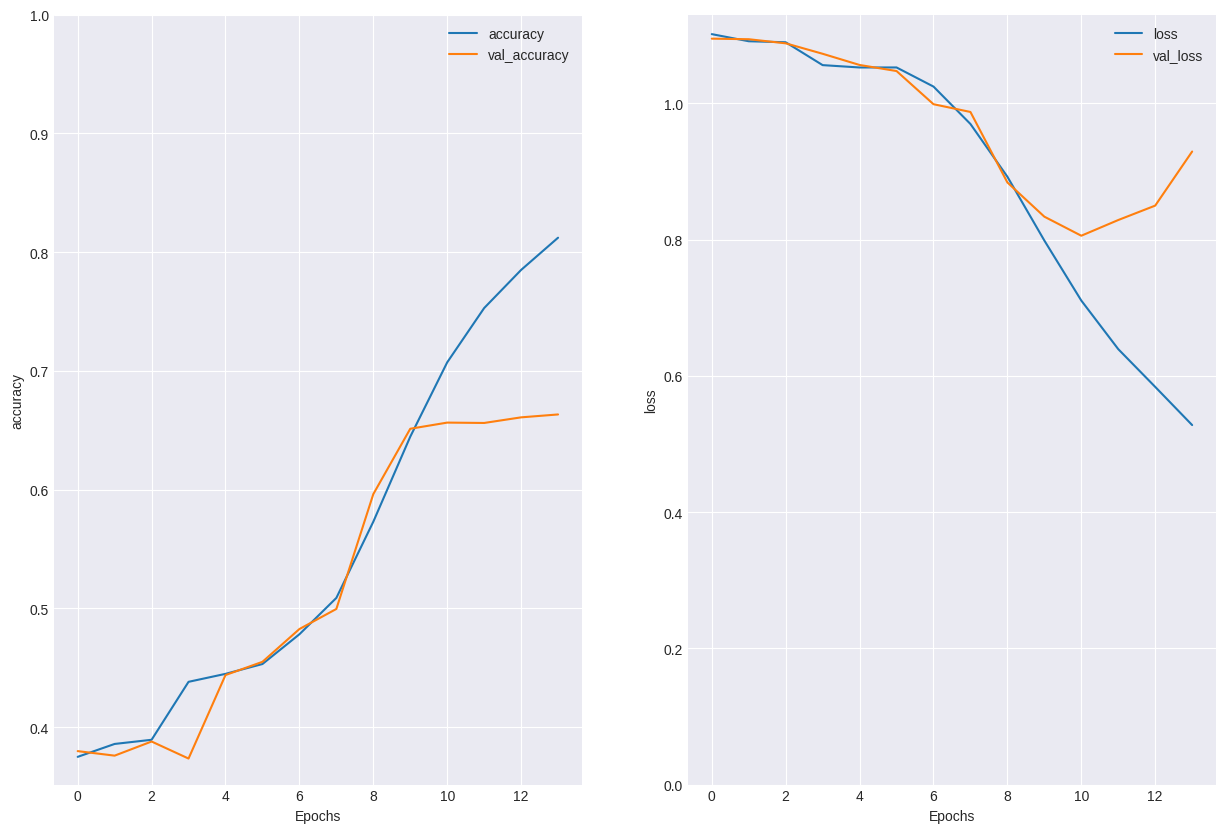

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history1, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history1, 'loss')
plt.ylim(0, None)

In [ ]:
score = model1.evaluate(test_padding,y_test.toarray())
print("Testing Accuracy(%): ", score[1]*100)

y_pred = model1.predict(test_padding)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in y_test])

114/114 [==============================] - 1s 9ms/step - loss: 0.9650 - accuracy: 0.6509
Testing Accuracy(%):  65.0933027267456
114/114 [==============================] - 1s 8ms/step


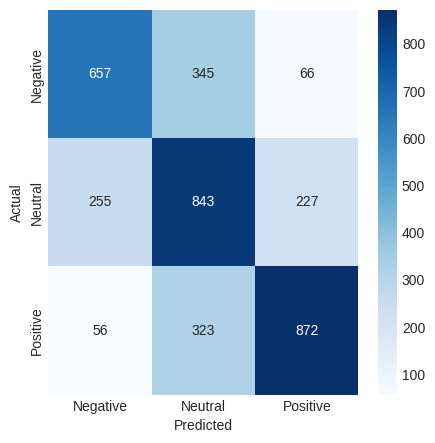

In [ ]:
cm = confusion_matrix(y_test_labels, y_predicted_labels)
labels=['Negative', 'Neutral','Positive']
plt.figure(figsize=(5,5))
sn.heatmap(cm,  xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
print('\n=================Classification Report========================\n')
print(classification_report(y_test_labels, y_predicted_labels, target_names=['Class  Negative',	 'Class Neutral','Class positive']))



=================Classification Report========================

                 precision    recall  f1-score   support

Class  Negative       0.68      0.62      0.65      1068
  Class Neutral       0.56      0.64      0.59      1325
 Class positive       0.75      0.70      0.72      1251

       accuracy                           0.65      3644
      macro avg       0.66      0.65      0.65      3644
   weighted avg       0.66      0.65      0.65      3644



# **BiDirectionalLSTM**

In [ ]:
#Building the model
model2 = Sequential([
    Embedding(50000,128,input_length=train_padding.shape[1]),
    Bidirectional(LSTM(128,return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(32,activation='relu'),
    Dropout(0.5),
    Dense(3,activation='softmax')
])
#Compiling the model
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#Fitting the model
history2 =  model2.fit(train_padding,y_train ,epochs=15, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=2)])


Epoch 1/15
820/820 [==============================] - 266s 313ms/step - loss: 0.8839 - accuracy: 0.5783 - val_loss: 0.7309 - val_accuracy: 0.6812
Epoch 2/15
820/820 [==============================] - 262s 320ms/step - loss: 0.6487 - accuracy: 0.7366 - val_loss: 0.7138 - val_accuracy: 0.6917
Epoch 3/15
820/820 [==============================] - 278s 340ms/step - loss: 0.4927 - accuracy: 0.8112 - val_loss: 0.8450 - val_accuracy: 0.6827
Epoch 4/15
820/820 [==============================] - 270s 330ms/step - loss: 0.3747 - accuracy: 0.8616 - val_loss: 0.8648 - val_accuracy: 0.6743


(0.0, 0.909385870397091)

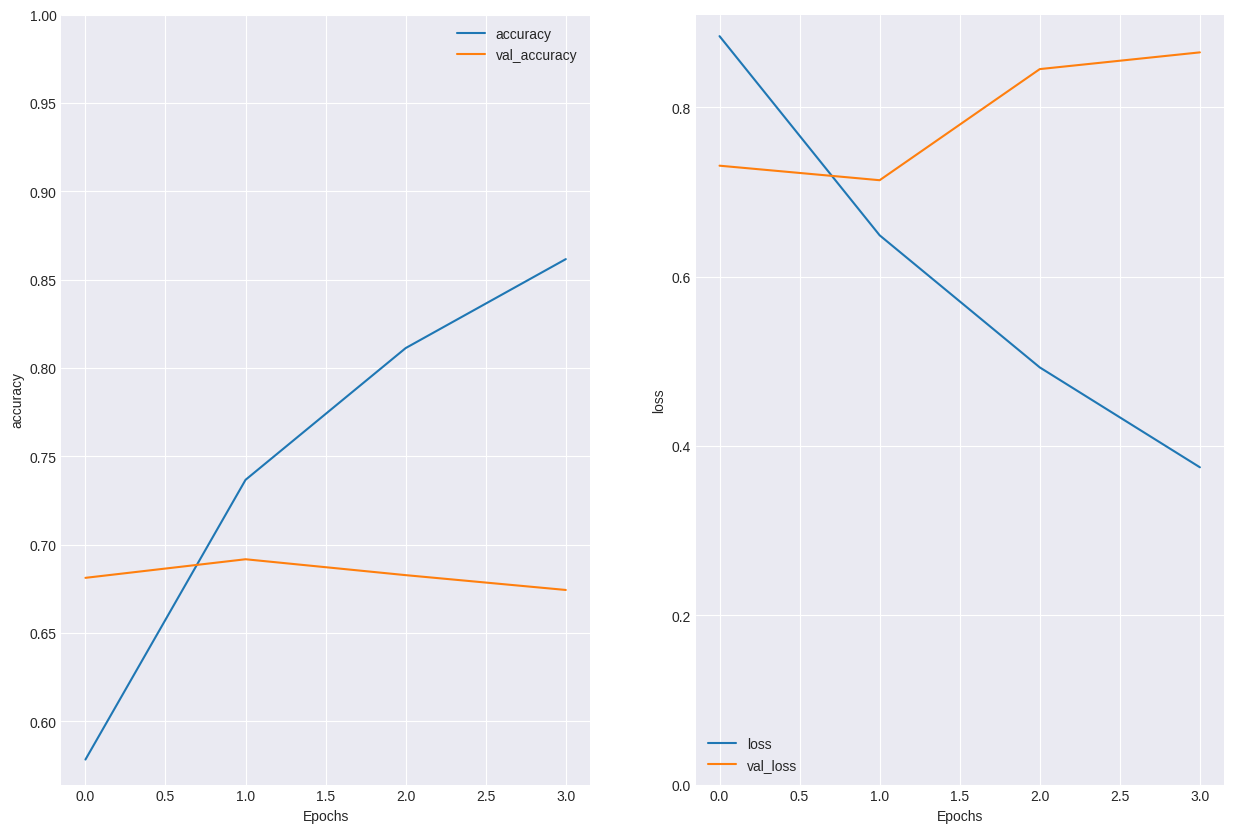

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history2, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history2, 'loss')
plt.ylim(0, None)

114/114 [==============================] - 9s 80ms/step - loss: 0.9200 - accuracy: 0.6509
Testing Accuracy(%):  65.0933027267456
114/114 [==============================] - 11s 80ms/step


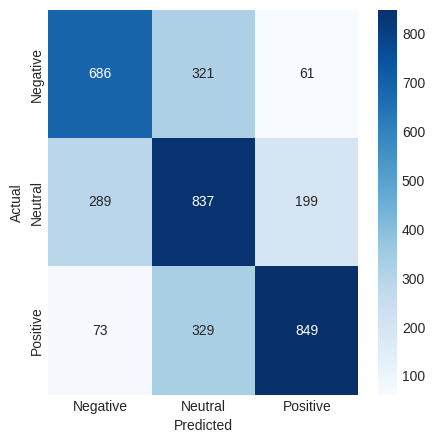

In [ ]:
score = model2.evaluate(test_padding,y_test.toarray())
print("Testing Accuracy(%): ", score[1]*100)

y_pred = model2.predict(test_padding)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in y_test])

cm = confusion_matrix(y_test_labels, y_predicted_labels)
labels=['Negative', 'Neutral','Positive']
plt.figure(figsize=(5,5))
sn.heatmap(cm,  xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print('\n=================Classification Report for Bidirectional LSTM========================\n')
print(classification_report(y_test_labels, y_predicted_labels, target_names=['Class  Negative',	 'Class Neutral','Class positive']))



=================Classification Report for Bidirectional LSTM========================

                 precision    recall  f1-score   support

Class  Negative       0.71      0.62      0.67      1056
  Class Neutral       0.60      0.71      0.65      1383
 Class positive       0.77      0.69      0.72      1205

       accuracy                           0.68      3644
      macro avg       0.69      0.67      0.68      3644
   weighted avg       0.69      0.68      0.68      3644

